<h1 style="text-align: center; font-weight: bold;">
Model LSTM for Time Series Forecasting Temperature
</h1>


# LLibreries

In [1]:
# üì¶ Gesti√≥ b√†sica de dades i formats
import os
import json
import random
import warnings
from datetime import datetime
from itertools import combinations

# üìä Tractament i visualitzaci√≥ de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import plotly.express as px

# Configuraci√≥ visuals
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")  # Ignorar warnings per evitar soroll

# üìà Barra de progr√©s
from tqdm.notebook import tqdm

# üß™ Preprocessament i m√®triques
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error)

# ü§ñ TensorFlow i Keras ‚Äî Xarxes LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, LSTM
from keras import Model


# Funcions pr√≤pies
import importlib
import lstm_functions
importlib.reload(lstm_functions)
from lstm_functions import *



2025-06-20 14:43:38.688213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 14:43:38.726339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Importacic√≥ Dades


## Importaci√≥ de dades dades des de CSV

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [2]:
#Directori de treball

# Ruta on esta el script actual
__path__ = os.getcwd() # Si es fitxer .ipynb
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py

# Carpeta on es troben les dades
carpeta_dades = '../0_Data/Dades_T_estacions_xema_Z1'


# Directori on es guarden els models entrenats del Notebook
carpeta_model = 'models_proves_confeccio'

# Fitxers de dades
fitxer_dades_csv = 'SCM_T_Z1.csv' # Nom del fitxer CSV amb totes les dades
fitxer_dades_csv_2009_2019 = 'SCM_T_Z1_2009_2019.csv' # Nom del fitxer CSV amb les dades de 2009 a 2019
fitxer_dades_csv_2020_2024 = 'SCM_T_Z1_2020_2024.csv' # Nom del fitxer CSV amb les dades de 2020 a 2024 (final dades)

# Path complet al fitxer CSV
path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)
path_dades_2009_2019 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2009_2019)
path_dades_2020_2024 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2020_2024)


# Importar les dades 2020_2024 per LSTM ja que son recents i no tenen interrupcions ni valors nuls

df_lstm = pd.read_csv(path_dades_2020_2024)

# Convertir la columna 'data' a tipus datetime
df_lstm['data'] = pd.to_datetime(df_lstm['data'], utc=True)

# Comprovar si hi ha valors nuls
print("Valors nuls per columna en dades LSTM:")
print(df_lstm.isnull().sum())

# Mostrar el df

df_lstm


Valors nuls per columna en dades LSTM:
data     0
valor    0
dtype: int64


data  valor
0     2020-01-01 00:00:00+00:00   1.30
1     2020-01-01 01:00:00+00:00   1.60
2     2020-01-01 02:00:00+00:00   3.20
3     2020-01-01 03:00:00+00:00   4.40
4     2020-01-01 04:00:00+00:00   4.00
...                         ...    ...
43843 2024-12-31 19:00:00+00:00   0.10
43844 2024-12-31 20:00:00+00:00  -0.60
43845 2024-12-31 21:00:00+00:00  -0.60
43846 2024-12-31 22:00:00+00:00  -0.70
43847 2024-12-31 23:00:00+00:00  -0.80

[43848 rows x 2 columns]

### Visualitzaci√≥ Pr√®via de les dades

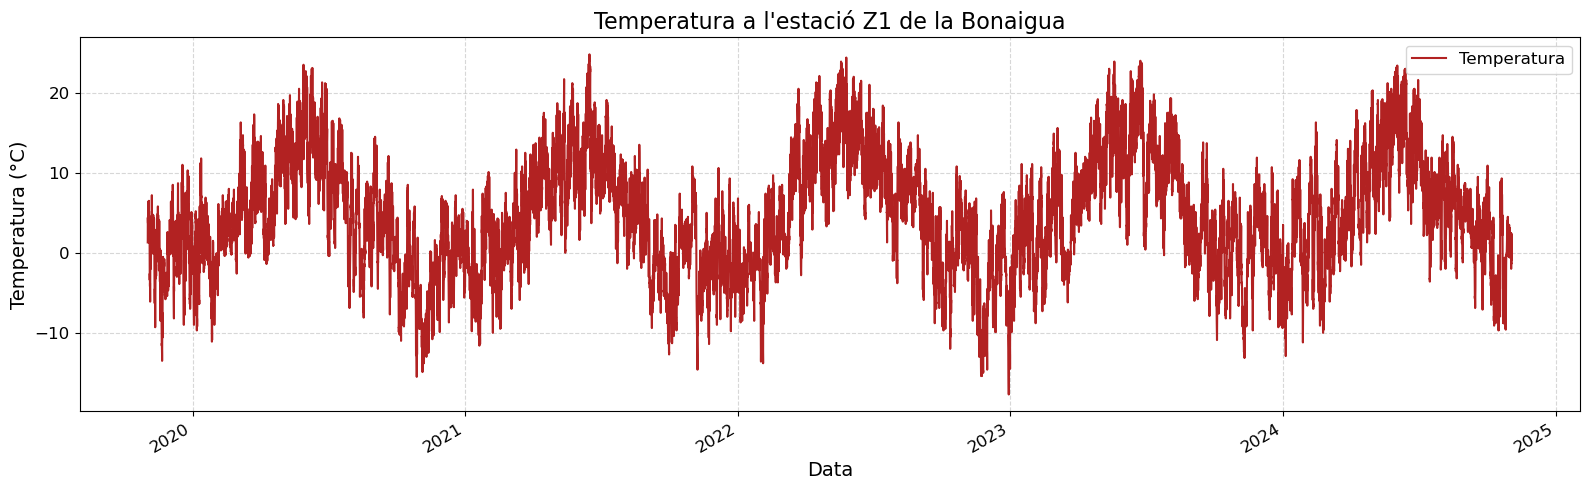

In [3]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estaci√≥ Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l‚Äôeix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Preparaci√≥ de les dades

## Split Train , validation i test

In [4]:
# Definim les dates l√≠mit per la separaci√≥
data_max = df_lstm['data'].max()

data_limit_train = data_max - pd.DateOffset(months=6)      # L√≠mit final del train
data_limit_val = data_max - pd.DateOffset(months=3)        # L√≠mit final de la validaci√≥

# Separem els datasets
df_train = df_lstm[df_lstm['data'] <= data_limit_train].copy().reset_index(drop=True)
df_val = df_lstm[(df_lstm['data'] > data_limit_train) & (df_lstm['data'] <= data_limit_val)].copy().reset_index(drop=True)
df_test = df_lstm[df_lstm['data'] > data_limit_val].copy().reset_index(drop=True)


# Observem com queden les dades
print('Train dataset shape:', df_train.shape)
print('Validation dataset shape:', df_val.shape)
print('Test dataset shape:', df_test.shape)

    

Train dataset shape: (39432, 2)
Validation dataset shape: (2208, 2)
Test dataset shape: (2208, 2)


### Visualitzaci√≥ dels conjunts de dades Train, Validation i Test

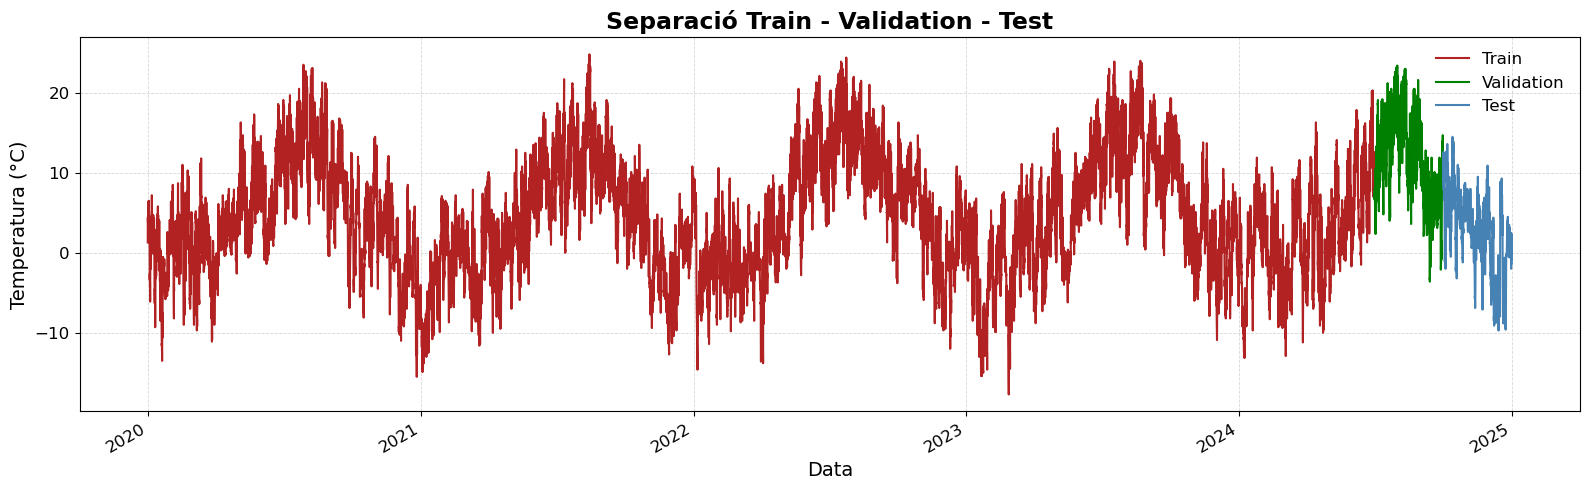

In [5]:
# Confirmem la separaci√≥ amb un gr√†fic
plt.figure(figsize=(16, 5))
plt.plot(df_train['data'], df_train['valor'], label='Train', color='firebrick', linewidth=1.5)
plt.plot(df_val['data'], df_val['valor'], label='Validation', color='green', linewidth=1.5)
plt.plot(df_test['data'], df_test['valor'], label='Test', color='steelblue', linewidth=1.5)

plt.title('Separaci√≥ Train - Validation - Test', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


## Escalat de les dades per introduir-les al model LSTM

In [5]:
# Escalem la data

scaler = MinMaxScaler()

# Escalar nom√©s sobre train i transformar val i test
df_train['valor_scaled'] = scaler.fit_transform(df_train[['valor']])
df_val['valor_scaled'] = scaler.transform(df_val[['valor']])
df_test['valor_scaled'] = scaler.transform(df_test[['valor']])


# Observem com queden les dades

print('Train dataset shape:', df_train.shape)
# display(df_train.head())

print('Validation dataset shape:', df_val.shape)
# display(df_val.head())

print('Test dataset shape:', df_test.shape)
# display(df_test.head())

Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)


# üß† Model LSTM ‚Äî 1 output 

## Preparaci√≥ de les seq√º√®ncies per a l'entrenament

In [7]:
# Parametres Globals del model LSTM

# Parametritzaci√≥ per a la creaci√≥ de seq√º√®ncies 
WINDOW_SIZE = 24  # provar m√©s tard 48, 72, 168...
N_OUTPUTS = 1  # Per predicci√≥ simple, si fos multi-step seria > 1
N_SLIDE = 1  # Despla√ßament de la finestra, 1 per predicci√≥ simple
N_FEATURES = 1  # Nom√©s una variable: temperatura

In [8]:
# Creem una copia del df_test per evitar canviar el df original i afegim les dades escalades i les posteriors prediccions
df_test_pred = df_test.copy()

# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)


# Mostrem les dimensions dels conjunts de dades
print("üßæ Dimensions dels conjunts:")
print("")
print(f"  üìò Train ‚Üí X: {X_train.shape} | y: {y_train.shape}")
print("---------------------------")
print(f"  üìô Validaci√≥ ‚Üí X: {X_val.shape} | y: {y_val.shape}")
print("---------------------------")
print(f"  üìï Test ‚Üí X: {X_test.shape} | y: {y_test.shape}")

üßæ Dimensions dels conjunts:

  üìò Train ‚Üí X: (39408, 24, 1) | y: (39408, 1)
---------------------------
  üìô Validaci√≥ ‚Üí X: (2184, 24, 1) | y: (2184, 1)
---------------------------
  üìï Test ‚Üí X: (2184, 24, 1) | y: (2184, 1)


## Deficini√≥ del Model


In [9]:
# =================================================
# Creem el directori per guardar/carregar el model 
# =================================================

nom_model = 'lstm_model.h5'
model_path = os.path.join(__path__, carpeta_model, nom_model)
os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Assegurem que el directori existeix

In [10]:

# ============================
# Definim el model LSTM
# ============================

model = Sequential([
    # 1a capa LSTM amb 64 neurones (unitats)
    # - return_sequences=True perqu√® tenim m√©s capes LSTM despr√©s
    # - input_shape = (timesteps, features) ‚Üí cada seq√º√®ncia t√© X valors de temperatura (1 feature)
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),

    # Dropout per reduir overfitting (desactiva aleat√≤riament un 20% de les neurones durant l'entrenament)
    Dropout(0.2),

    # 2a capa LSTM (encara retorna seq√º√®ncies per passar-les a la seg√ºent LSTM)
    LSTM(64, return_sequences=True),
    Dropout(0.2),

    # 3a capa LSTM (√∫ltima ‚Üí no retorna seq√º√®ncia, nom√©s la sortida final)
    LSTM(64),
    Dropout(0.2),

    # Capa de sortida Dense:
    # - 1 neurona perqu√® fem una predicci√≥ escalar (una sola temperatura)
    Dense(N_OUTPUTS)
])

# Compilaci√≥ del model:
# - Optimitzador Adam ‚Üí ajusta els pesos de forma eficient
# - Funci√≥ de p√®rdua MSE ‚Üí ideal per problemes de regressi√≥ com el nostre

model.compile(
    optimizer='adam',
    loss='mse'
)


## Entrenament del Model

In [11]:
# =========================================================
# Entrenament del model multi-output
# =========================================================

# Reprodu√Øbilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [12]:

# Callback EarlyStopping per aturar l'entrenament si no millora el val_loss
early_stop = EarlyStopping(
    monitor='val_loss',      # monitoritza la p√®rdua de validaci√≥
    patience=5,              # espera 5 epochs sense millora abans d'aturar
    restore_best_weights=True  # recupera els pesos del millor epoch
)


In [13]:

# Entrenament del model:
# - epochs = 50 ‚Üí nombre d'iteracions sobre tot el dataset
# - batch_size = 32 ‚Üí nombre de mostres processades abans d'actualitzar els pesos
# - shuffle = False ‚Üí mantenim l'ordre de les dades per m√©s control

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32, # mida del lot per l'entrenament
    validation_data=(X_val, y_val),  # validaci√≥ amb dades de validaci√≥ separades
    callbacks=[early_stop],
    verbose=1,
    shuffle=False  # opcional, si vols control total de l'ordre
)

Epoch 1/50
1232/1232 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 20ms/step - loss: 0.0118 - val_loss: 0.0026
Epoch 2/50
1232/1232 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 21ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 3/50
1232/1232 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 28s 22ms/step - loss: 0.0015 - val_loss: 5.5830e-04
Epoch 4/50
1232/1232 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 21ms/step - loss: 0.0011 - val_loss: 8.9372e-04
Epoch 5/50
1232/1232 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 19ms/step - loss: 8.8240e-04 - val_loss: 5.7850e-04
Epoch 6/50
1232/1232 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 19ms/step - loss: 8.1599e-04 - val_loss: 5.3230e-04
Epoch 7/50
1232/1232 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 20ms/step - loss: 7.6508e-04 - val_loss: 4.6030e-04
Epoch 8/50
1232/1232 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [14]:
print(model.summary())

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 24, 64)         ‚îÇ        16,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 24, 64)         ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                   ‚îÇ (None, 64)             ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 249,029 (972.77 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,020 (648.52 KB)

None


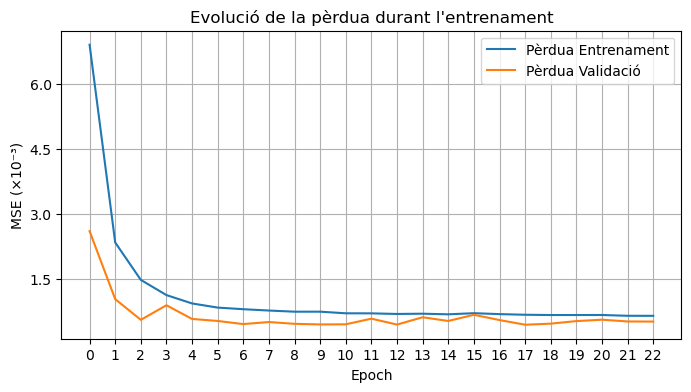

In [15]:
# ============================================
# Gr√†fic de la p√®rdua durant l'entrenament
# ============================================

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(history.history['loss'], label='P√®rdua Entrenament')
ax.plot(history.history['val_loss'], label='P√®rdua Validaci√≥')
ax.set_title("Evoluci√≥ de la p√®rdua durant l'entrenament")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (√ó10‚Åª¬≥)")

# Per ticks x cada 2 epochs
ax.set_xticks(np.arange(0, len(history.history['loss']), 1))

# Format ticks y amb 1 decimal
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))

# For√ßa ticks a enters (per√≤ com fem decimals, pot ser opcional)
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))  # nbins controla nombre m√†xim ticks

ax.legend()
ax.grid(True)
plt.show()


In [16]:
# =======================================
# Guardem i carreguem el model entrenat
# =======================================

# Guarda nom√©s l'arquitectura i els pesos, sense optimitzador ni funci√≥ de p√®rdua
model.save(model_path, include_optimizer=False)

## Carregar Model (Si ja tenim un entrenat)

In [17]:
# Carrega del model guardat
model = load_model(model_path)
print("Model carregat correctament des de:", model_path)
print(model.summary())

Model carregat correctament des de: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_proves/lstm_model.h5


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 24, 64)         ‚îÇ        16,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 24, 64)         ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                   ‚îÇ (None, 64)             ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 83,009 (324.25 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

None


## Prediccions del model 

### Predicci√≥ batch

In [18]:
df_test_pred = prediccio_batch(model, X_test, df_test_pred, scaler, nom_columna='pred_batch')

In [19]:
# Avaluaci√≥ de les m√®triques

rmse_batch = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_batch'][WINDOW_SIZE:]))
mse_batch = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_batch'][WINDOW_SIZE:])
mae_batch = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_batch'][WINDOW_SIZE:])


print(f"üìä M√®triques predicci√≥ batch: ")
print(f"   ‚ñ∏ RMSE: {rmse_batch:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_batch:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_batch:.4f} ¬∞C")

üìä M√®triques predicci√≥ batch: 
   ‚ñ∏ RMSE: 0.7932 ¬∞C
   ‚ñ∏ MSE: 0.6292 ¬∞C¬≤
   ‚ñ∏ MAE: 0.5331 ¬∞C


### Predicci√≥ Multi-Step Iterativa

In [20]:
df_test_pred = prediccio_step_iterativa(model, X_test, df_test_pred, scaler, nom_columna='pred_iter')

In [21]:
# Avaluaci√≥ de les m√®triques

rmse_iter = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_iter'][WINDOW_SIZE:]))
mse_iter = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_iter'][WINDOW_SIZE:])
mae_iter = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_iter'][WINDOW_SIZE:])


print(f"üìä M√®triques predicci√≥ iterativa: ")
print(f"   ‚ñ∏ RMSE: {rmse_iter:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_iter:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_iter:.4f} ¬∞C")

üìä M√®triques predicci√≥ iterativa: 
   ‚ñ∏ RMSE: 15.0439 ¬∞C
   ‚ñ∏ MSE: 226.3182 ¬∞C¬≤
   ‚ñ∏ MAE: 14.2061 ¬∞C


### Predicci√≥ iterativa amb reinjecci√≥ de dades

In [22]:
df_test_pred = prediccio_iterativa_reinjection(model, X_test, df_test_pred, scaler, reinjeccio=5, nom_columna='pred_reinject')

In [23]:
# Avaluaci√≥ de les m√®triques

rmse_reinj = np.sqrt(mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_reinject'][WINDOW_SIZE:]))
mse_reinj = mean_squared_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_reinject'][WINDOW_SIZE:])
mae_reinj = mean_absolute_error(df_test_pred['valor'][WINDOW_SIZE:], df_test_pred['pred_reinject'][WINDOW_SIZE:])


print(f"üìä M√®triques predicci√≥ amb reinjecci√≥: ")
print(f"   ‚ñ∏ RMSE: {rmse_reinj:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_reinj:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_reinj:.4f} ¬∞C")

üìä M√®triques predicci√≥ amb reinjecci√≥: 
   ‚ñ∏ RMSE: 1.7729 ¬∞C
   ‚ñ∏ MSE: 3.1433 ¬∞C¬≤
   ‚ñ∏ MAE: 1.2162 ¬∞C


## M√®triques, errors i graficaci√≥ 

In [24]:
# Taula comparativa de m√®triques
metriques = pd.DataFrame({
    'M√®trica': ['RMSE', 'MSE', 'MAE'],
    'Predicci√≥ Batch': [rmse_batch, mse_batch, mae_batch],
    'Predicci√≥ Iterativa': [rmse_iter, mse_iter, mae_iter],
    'Predicci√≥ Reinjecci√≥': [rmse_reinj, mse_reinj, mae_reinj]
})
metriques.set_index('M√®trica', inplace=True)
metriques = metriques.round(4)  # Arrodonim a 4 decimals
metriques

Predicci√≥ Batch  Predicci√≥ Iterativa  Predicci√≥ Reinjecci√≥
M√®trica                                                            
RMSE                0.79                15.04                  1.77
MSE                 0.63               226.32                  3.14
MAE                 0.53                14.21                  1.22

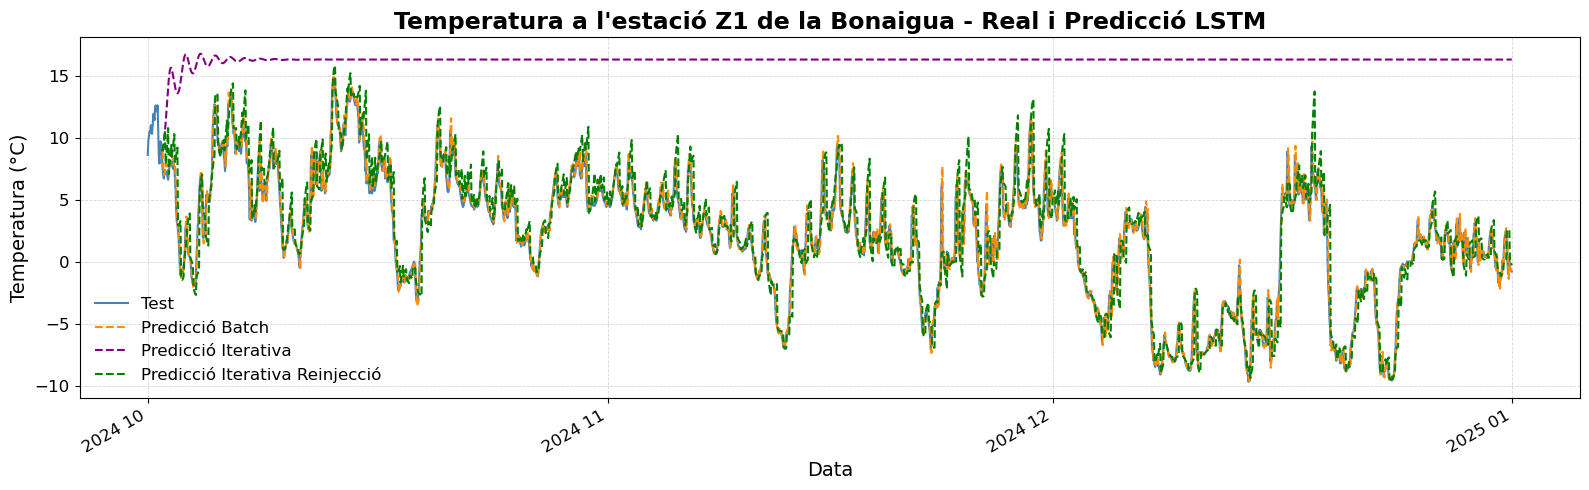

In [25]:
# Ploteig de les dades i les prediccions
plt.figure(figsize=(16, 5))  


# Defineix si es vol mostrar validaci√≥ i train √∫ltims X dies
# √öltims dies del train i validaci√≥

validation = False  # Si vols mostrar tamb√© la validaci√≥

dies_enrere = 0 # Dies enrere que vols mostrar del train (0 per no mostrar, >0 per mostrar els √∫ltims dies)
dies_enrere = max(dies_enrere, 0)  # Assegura que sigui >= 0

if validation == True:
    if dies_enrere > 0:

        # Ploteja √∫ltims dies de Train
        data_limit = df_train['data'].max() - pd.Timedelta(days=dies_enrere)
        df_train_filtrat = df_train[df_train['data'] >= data_limit]

        plt.plot(df_train_filtrat['data'], df_train_filtrat['valor'], label=f'Train (√∫ltims {dies_enrere} dies)', color='firebrick', linewidth=1.5)

    # Ploteja Validation (en tots els casos on validation=True)
    plt.plot(df_val['data'], df_val['valor'],label='Validation', color='darkgreen', linewidth=1.5)


# Plot Test complet
plt.plot(df_test_pred['data'], df_test_pred['valor'], label='Test', color='steelblue', linewidth=1.5)

# Plot Predicci√≥ Bacth
plt.plot(df_test_pred['data'], df_test_pred['pred_batch'], label='Predicci√≥ Batch', color='darkorange', linewidth=1.5, linestyle='--')

# Plot Predicci√≥ iterativa
plt.plot(df_test_pred['data'], df_test_pred['pred_iter'], label='Predicci√≥ Iterativa', color='purple', linewidth=1.5, linestyle='--')

# Plot Predicci√≥ iterativa amb reinjecci√≥
plt.plot(df_test_pred['data'], df_test_pred['pred_reinject'], label='Predicci√≥ Iterativa Reinjecci√≥', color='green', linewidth=1.5, linestyle='--')

plt.title('Temperatura a l\'estaci√≥ Z1 de la Bonaigua - Real i Predicci√≥ LSTM', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


# üìà Model Multioutput LSTM


## Preparaci√≥ de les seq√º√®ncies per a l'entrenament

In [6]:
# Parametres Globals del model LSTM

# Parametritzaci√≥ per a la creaci√≥ de seq√º√®ncies multi-step 
WINDOW_SIZE = 24  # provar m√©s tard 48, 72, 168...
N_OUTPUTS = 5  # Nombre de passos de predicci√≥ futura (multi-step)
N_SLIDE = N_OUTPUTS  # Despla√ßament de la finestra, 1 per predicci√≥ simple, n_outputs per multi-step (si les volem clavades, sense espai i sense solapament)
N_FEATURES = 1  # Nom√©s una variable: temperatura


In [7]:
# Creem una copia de df_test per aquest model multi-step
df_test_pred_multi = df_test.copy()


# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train, X_val i X_test seran les dades d'entrada, i y_train, y_val i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_val, y_val = create_sequences(df_val['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)
X_test, y_test = create_sequences(df_test_pred_multi['valor_scaled'].values, WINDOW_SIZE, n_outputs=N_OUTPUTS, n_slide=N_SLIDE)

print("üßæ Dimensions dels conjunts:")
print("")
print(f"  üìò Train ‚Üí X: {X_train.shape} | y: {y_train.shape}")
print("---------------------------")
print(f"  üìô Validaci√≥ ‚Üí X: {X_val.shape} | y: {y_val.shape}")
print("---------------------------")
print(f"  üìï Test ‚Üí X: {X_test.shape} | y: {y_test.shape}")


üßæ Dimensions dels conjunts:

  üìò Train ‚Üí X: (7881, 24, 1) | y: (7881, 5)
---------------------------
  üìô Validaci√≥ ‚Üí X: (436, 24, 1) | y: (436, 5)
---------------------------
  üìï Test ‚Üí X: (436, 24, 1) | y: (436, 5)


## Definici√≥ del Model Multioutput

In [9]:
# ========================================================================
# Creem el directori per guardar/carregar el model multi-output
# ========================================================================

nom_model_multi = 'lstm_model_multioutput.h5'
carpeta_model_multi = carpeta_model
model_multi_path = os.path.join(__path__, carpeta_model_multi, nom_model_multi)
os.makedirs(os.path.dirname(model_multi_path), exist_ok=True)

In [29]:
# ==================================================
# Definim el model LSTM multi-output
# ==================================================

model_multi = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, N_FEATURES)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(N_OUTPUTS)  # Capa final amb tantes neurones com outputs vulguem
])

model_multi.compile(
    optimizer='adam',
    loss='mse'
)

## Entrenament del Model Multioutput

In [30]:
# =========================================================
# Entrenament del model multi-output
# =========================================================

# Reproductibilitat
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [31]:

# Callback per early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [32]:

# Entrenament del model:
# - epochs = 50 ‚Üí nombre d'iteracions sobre tot el dataset
# - batch_size = 32 ‚Üí nombre de mostres processades abans d'actualitzar els pesos
# - shuffle = False ‚Üí mantenim l'ordre de les dades per m√©s control

history_multi = model_multi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

Epoch 1/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 18ms/step - loss: 0.0279 - val_loss: 0.0064
Epoch 2/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0083 - val_loss: 0.0061
Epoch 3/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 4/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 5/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 6/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 7/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 8/50
247/247 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 16ms/step - loss: 0.0033 - v

In [33]:
print(model_multi.summary())

Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_3 (LSTM)                   ‚îÇ (None, 24, 64)         ‚îÇ        16,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_4 (LSTM)                   ‚îÇ (None, 24, 64)         ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)             ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_5 (LSTM)                   ‚îÇ (None, 64)             ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_5 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 5)              ‚îÇ           325 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 249,809 (975.82 KB)

 Trainable params: 83,269 (325.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,540 (650.55 KB)

None


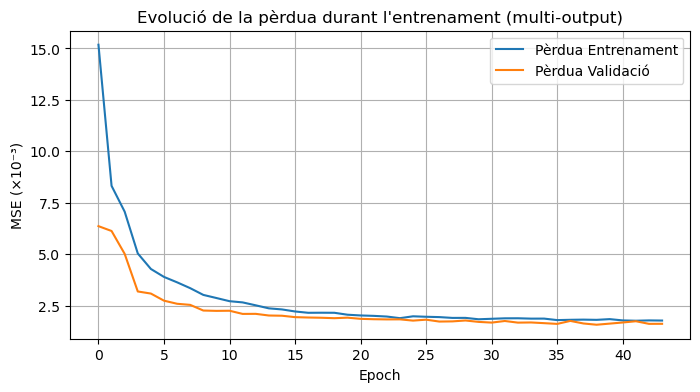

In [34]:
# ============================================
# Gr√†fic de la p√®rdua durant l'entrenament
# ============================================

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history_multi.history['loss'], label='P√®rdua Entrenament')
ax.plot(history_multi.history['val_loss'], label='P√®rdua Validaci√≥')
ax.set_title("Evoluci√≥ de la p√®rdua durant l'entrenament (multi-output)")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (√ó10‚Åª¬≥)")
ax.set_xticks(np.arange(0, len(history_multi.history['loss']), 5))
ax.yaxis.set_major_formatter(FuncFormatter(escala_mil))
ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=6))
ax.legend()
ax.grid(True)
plt.show()


In [35]:
# =======================================
# Guardem i carreguem el model entrenat
# =======================================

# Guarda nom√©s l'arquitectura i els pesos, sense optimitzador ni funci√≥ de p√®rdua
model_multi.save(model_multi_path, include_optimizer=False)

## Carregar Model Multi (Si ja tenim un entrenat)

In [10]:
# Carreguem el model
model_multi = load_model(model_multi_path)
print("Model carregat correctament des de:", model_multi_path)
print(model_multi.summary())


Model carregat correctament des de: /home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/models_prediccio/3_model_lstm/models_proves_confeccio/lstm_model_multioutput.h5


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_3 (LSTM)                   ‚îÇ (None, 24, 64)         ‚îÇ        16,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_4 (LSTM)                   ‚îÇ (None, 24, 64)         ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)             ‚îÇ (None, 24, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_5 (LSTM)                   ‚îÇ (None, 64)             ‚îÇ        33,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_5 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 5)              ‚îÇ           325 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 83,269 (325.27 KB)

 Trainable params: 83,269 (325.27 KB)

 Non-trainable params: 0 (0.00 B)

None


## Prediccions del model Multioutput

### Predicci√≥ batch multioutput

In [11]:
# Prova --> Resetejar el df_test_multi
df_test_pred_multi = df_test.copy()

df_test_pred_multi = prediccio_batch_multi(model_multi, X_test, df_test_pred_multi, scaler=scaler, window_size=WINDOW_SIZE, n_outputs=N_OUTPUTS, nom_columna='pred_batch')

In [17]:
df_test_pred_multi 

data  valor  valor_scaled  pred_batch
0    2024-10-01 00:00:00+00:00   8.60          0.62         NaN
1    2024-10-01 01:00:00+00:00   9.70          0.64         NaN
2    2024-10-01 02:00:00+00:00  10.20          0.66         NaN
3    2024-10-01 03:00:00+00:00  10.50          0.66         NaN
4    2024-10-01 04:00:00+00:00  10.40          0.66         NaN
...                        ...    ...           ...         ...
2203 2024-12-31 19:00:00+00:00   0.10          0.42        2.44
2204 2024-12-31 20:00:00+00:00  -0.60          0.40         NaN
2205 2024-12-31 21:00:00+00:00  -0.60          0.40         NaN
2206 2024-12-31 22:00:00+00:00  -0.70          0.40         NaN
2207 2024-12-31 23:00:00+00:00  -0.80          0.40         NaN

[2208 rows x 4 columns]

In [12]:
# Metriques de la predicci√≥ multi-output
rmse_batch_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_batch_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_batch_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_batch'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"üìä M√®triques predicci√≥ multi-output: ")
print(f"   ‚ñ∏ RMSE: {rmse_batch_multi:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_batch_multi:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_batch_multi:.4f} ¬∞C")

üìä M√®triques predicci√≥ multi-output: 
   ‚ñ∏ RMSE: 1.6669 ¬∞C
   ‚ñ∏ MSE: 2.7786 ¬∞C¬≤
   ‚ñ∏ MAE: 1.2692 ¬∞C


### Predicci√≥ multi-step iterativa multioutput

In [39]:
df_test_pred_multi = prediccio_step_iterativa_multi(model_multi, X_test, df_test_pred_multi, scaler, nom_columna='pred_iter')

In [40]:
# Metriques de la predicci√≥ multi-output
rmse_iter_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_iter'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_iter_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_iter'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_iter_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_iter'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"üìä M√®triques predicci√≥ multi-output iterativa: ")
print(f"   ‚ñ∏ RMSE: {rmse_iter_multi:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_iter_multi:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_iter_multi:.4f} ¬∞C")

üìä M√®triques predicci√≥ multi-output iterativa: 
   ‚ñ∏ RMSE: 10.6166 ¬∞C
   ‚ñ∏ MSE: 112.7113 ¬∞C¬≤
   ‚ñ∏ MAE: 9.4596 ¬∞C


### Predicci√≥ amb reinjecci√≥ de dades real multioutput

In [46]:
df_test_pred_multi = prediccio_iterativa_reinjection_multi(model_multi, X_test, df_test_pred_multi, scaler, reinjeccio=5, nom_columna='pred_reinject')

In [47]:
# Metriques de la predicci√≥ multi-output
rmse_reinj_multi = np.sqrt(mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_reinject'][WINDOW_SIZE:(1-N_OUTPUTS)]))
mse_reinj_multi = mean_squared_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_reinject'][WINDOW_SIZE:(1-N_OUTPUTS)])
mae_reinj_multi = mean_absolute_error(df_test_pred_multi['valor'][WINDOW_SIZE:(1-N_OUTPUTS)], df_test_pred_multi['pred_reinject'][WINDOW_SIZE:(1-N_OUTPUTS)])
    

print(f"üìä M√®triques predicci√≥ multi-output reinject:")
print(f"   ‚ñ∏ RMSE: {rmse_reinj_multi:.4f} ¬∞C")
print(f"   ‚ñ∏ MSE: {mse_reinj_multi:.4f} ¬∞C¬≤")
print(f"   ‚ñ∏ MAE: {mae_reinj_multi:.4f} ¬∞C")

üìä M√®triques predicci√≥ multi-output reinject:
   ‚ñ∏ RMSE: 4.0428 ¬∞C
   ‚ñ∏ MSE: 16.3438 ¬∞C¬≤
   ‚ñ∏ MAE: 3.0943 ¬∞C


## Metriques, errors i graficaci√≥ multioutput

In [16]:
# Taula comparativa de m√®triques
metriques_multi = pd.DataFrame({
    'M√®trica': ['RMSE', 'MSE', 'MAE'],
    'Predicci√≥ Batch': [rmse_batch_multi, mse_batch_multi, mae_batch_multi],
    # 'Predicci√≥ Iterativa': [rmse_iter_multi, mse_iter_multi, mae_iter_multi],
    # 'Predicci√≥ Reinjecci√≥': [rmse_reinj_multi, mse_reinj_multi, mae_reinj_multi]
})
metriques_multi.set_index('M√®trica', inplace=True)
metriques_multi = metriques_multi.round(4)  # Arrodonim a 4 decimals
metriques_multi

Predicci√≥ Batch
M√®trica                 
RMSE                1.67
MSE                 2.78
MAE                 1.27

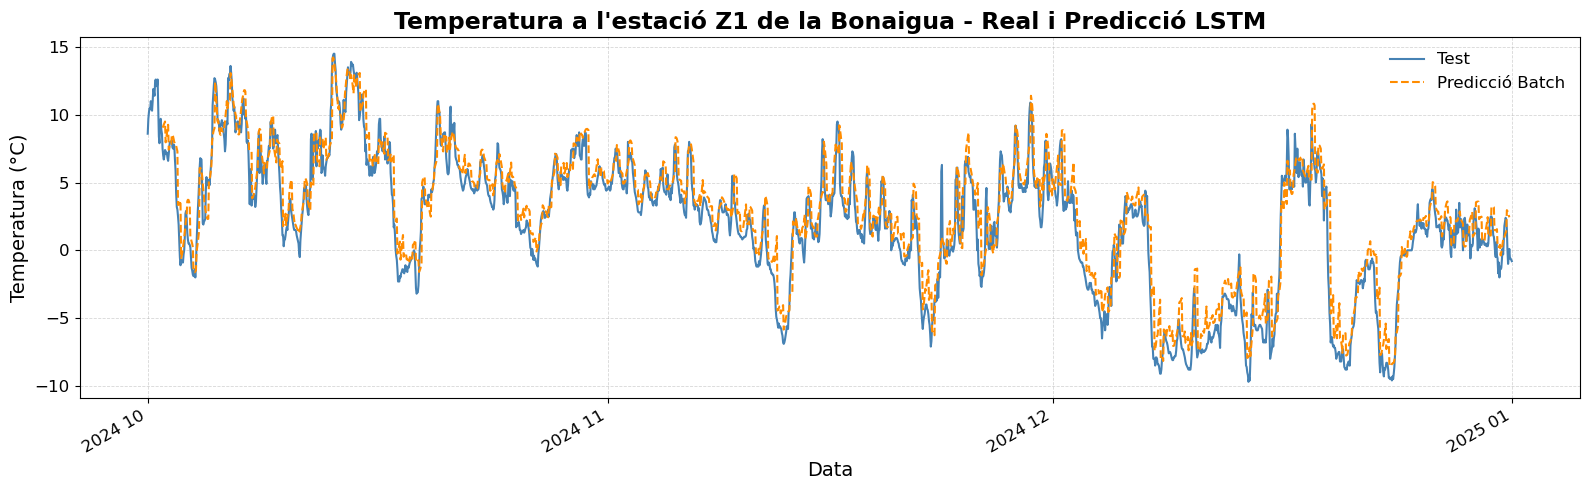

In [15]:
# Ploteig de les dades i les prediccions
plt.figure(figsize=(16, 5))  


# Defineix si es vol mostrar validaci√≥ i train √∫ltims X dies
# √öltims dies del train i validaci√≥

validation = False  # Si vols mostrar tamb√© la validaci√≥

dies_enrere = 0 # Dies enrere que vols mostrar del train (0 per no mostrar, >0 per mostrar els √∫ltims dies)
dies_enrere = max(dies_enrere, 0)  # Assegura que sigui >= 0

if validation == True:
    if dies_enrere > 0:

        # Ploteja √∫ltims dies de Train
        data_limit = df_train['data'].max() - pd.Timedelta(days=dies_enrere)
        df_train_filtrat = df_train[df_train['data'] >= data_limit]

        plt.plot(df_train_filtrat['data'], df_train_filtrat['valor'], label=f'Train (√∫ltims {dies_enrere} dies)', color='firebrick', linewidth=1.5)

    # Ploteja Validation (en tots els casos on validation=True)
    plt.plot(df_val['data'], df_val['valor'],label='Validation', color='darkgreen', linewidth=1.5)


# Plot Test complet
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['valor'], label='Test', color='steelblue', linewidth=1.5)

# Plot Predicci√≥ Bacth
plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_batch'], label='Predicci√≥ Batch', color='darkorange', linewidth=1.5, linestyle='--')

# Plot Predicci√≥ iterativa
# plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_iter'], label='Predicci√≥ Iterativa', color='purple', linewidth=1.5, linestyle='--')

# Plot Predicci√≥ iterativa amb reinjecci√≥
# plt.plot(df_test_pred_multi['data'], df_test_pred_multi['pred_reinject'], label='Predicci√≥ Iterativa Reinjecci√≥', color='darkgreen', linewidth=1.5, linestyle='--')

plt.title('Temperatura a l\'estaci√≥ Z1 de la Bonaigua - Real i Predicci√≥ LSTM', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()
